In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [16]:
# provided helper functions

# forces
def forces(x,y,A):
    N = np.size(A,axis = 0)
    # find pairwise distances 
    xaux = np.outer(x,np.ones(np.shape(x)))
    yaux = np.outer(y,np.ones(np.shape(x)))
    dx = A*(xaux - np.transpose(xaux))
    dy = A*(yaux - np.transpose(yaux))
    dxy = np.sqrt(dx**2 + dy**2)
    # spring forces due to linked vertices
    # optimal distance between linked vertices is 1 
    Aind = np.argwhere(A == 1)
    idiff = np.zeros(np.shape(A))
    Nlinks = np.size(Aind,axis = 0)
    for j in range(Nlinks):
        idiff[Aind[j,0],Aind[j,1]] = 1 - 1/dxy[Aind[j,0],Aind[j,1]]
    
    fx = -np.sum(idiff*dx,axis = 1)
    afx = np.minimum(np.abs(fx),np.ones(np.size(fx)))
    sfx = np.sign(fx)
    fx = afx*sfx
                  
    fy = -np.sum(idiff*dy,axis = 1)
    afy = np.minimum(np.abs(fy),np.ones(np.size(fy)))
    sfy = np.sign(fy)
    fy = afy*sfy
    
    f_linked = np.concatenate((fx,fy),axis = 0)
    
    # repelling spring forces due to unlinked vertices
    # repelling is on if the distance between unlined verticas is greater than sqrt(3)
    h = np.sqrt(3.0)
    A1 = np.ones(np.shape(A)) - A
    dx = A1*(xaux - np.transpose(xaux))
    dy = A1*(yaux - np.transpose(yaux))
    dxy = np.sqrt(dx**2 + dy**2)
    mask = np.zeros(np.shape(A))
    diff = A1*(dxy - h)
    mask = np.minimum(diff,np.zeros(np.shape(diff)))
    fx = np.sum(mask*dx,axis=1)
    fy = np.sum(mask*dy,axis=1)
    f_unlinked = -np.concatenate((fx,fy),axis = 0)
    
    return np.reshape(f_linked + f_unlinked, (182,1))

# plot graph
def plot_graph(x,y,A):
    plt.figure(figsize=(12, 12))
    Aind = np.argwhere(A == 1)
    Nlinks = np.size(Aind,axis = 0)
    for j in range(Nlinks):
        plt.plot([x[Aind[j,0]],x[Aind[j,1]]],[y[Aind[j,0]],y[Aind[j,1]]],linewidth = 4,c = (0,0,0.5))
    plt.scatter(x,y,s=200,c='r')
    axes=plt.gca()
    axes.set_aspect(1)
    plt.axis('off')

In [6]:
# read CSV
AdjMatrix = pd.read_csv('Adjacency_matrix.csv', header=None)
AdjMatrix = AdjMatrix.to_numpy()

In [145]:
# initialize x and y
x = np.random.randn(91,1)*91
y = np.random.randn(91,1)*91

In [146]:
# Nesterov Optimizer
no_epochs = 50000
alpha = 1e-2
m = 0.9
last_change = np.zeros((182,1))

g = -forces(x,y,AdjMatrix)
Fs = np.zeros((no_epochs+1,1))
Fs[0] = np.linalg.norm(g)
print("Initially ||F|| = " + str(np.linalg.norm(g)))
for i in range(1,no_epochs+1):
    projX = x + last_change[0:91]*m
    projY = y + last_change[91:182]*m
    g = -forces(projX, projY,AdjMatrix)
    last_change = (m*last_change) - alpha*g
    x = x + last_change[0:91]
    y = y + last_change[91:182]
    Fs[i] = np.linalg.norm(g)
    print("i = " + str(i) + " ||F|| = " + str(np.linalg.norm(g)))


Initially ||F|| = 13.490737563232042
i = 1 ||F|| = 13.490737563232042
i = 2 ||F|| = 13.490737563232042
i = 3 ||F|| = 13.490737563232042
i = 4 ||F|| = 13.490737563232042
i = 5 ||F|| = 13.490737563232042
i = 6 ||F|| = 13.490737563232042
i = 7 ||F|| = 13.490521325645236
i = 8 ||F|| = 13.490164894832303
i = 9 ||F|| = 13.490548153887572
i = 10 ||F|| = 13.491123187040854
i = 11 ||F|| = 13.491269867088208
i = 12 ||F|| = 13.490737563232042
i = 13 ||F|| = 13.490737563232042
i = 14 ||F|| = 13.490737563232042
i = 15 ||F|| = 13.490737563232042
i = 16 ||F|| = 13.490737563232042
i = 17 ||F|| = 13.490737563232042
i = 18 ||F|| = 13.490737563232042
i = 19 ||F|| = 13.490737563232042
i = 20 ||F|| = 13.490737563232042
i = 21 ||F|| = 13.490737563232042
i = 22 ||F|| = 13.490737563232042
i = 23 ||F|| = 13.490737563232042
i = 24 ||F|| = 13.490737563232042
i = 25 ||F|| = 13.490737563232042
i = 26 ||F|| = 13.490737563232042
i = 27 ||F|| = 13.490737563232042
i = 28 ||F|| = 13.490737563232042
i = 29 ||F|| = 13.49

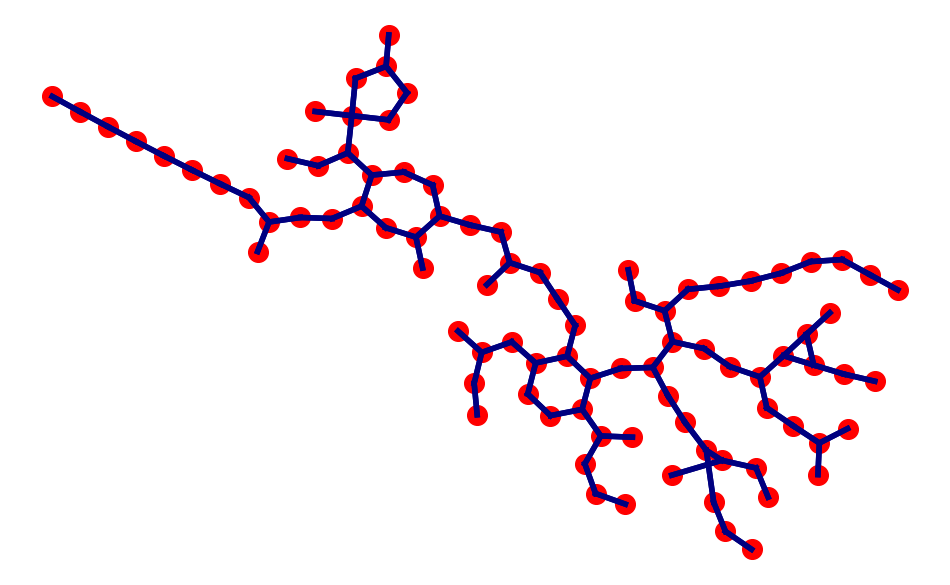

In [147]:
plot_graph(x,y,AdjMatrix)

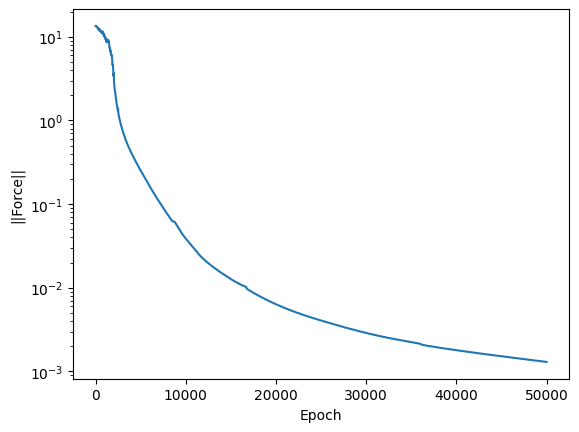

In [148]:
plt.plot(range(0,no_epochs+1), Fs)
plt.xlabel("Epoch")
plt.ylabel("||Force||")
plt.yscale("log")